In [ ]:
!pip install kaggle

In [ ]:
!mkdir ~/.kaggle

In [ ]:
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download adityajn105/flickr8k

100% 1.03G/1.04G [00:09<00:00, 131MB/s]
100% 1.04G/1.04G [00:09<00:00, 114MB/s]


In [ ]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.models import Model
import os

In [ ]:
token_path = "/content/Flickr8k.token.txt"
train_images_path = "/content/Flickr_8k.trainImages.txt"
test_images_path = "/content/Flickr_8k.testImages.txt"
images_path = "/content/Images"

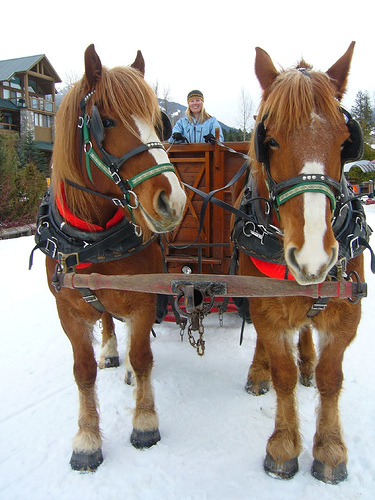

In [ ]:
from IPython.display import Image
Image('/content/Images/109202801_c6381eef15.jpg')

In [ ]:
# load the caption file & read it
def load_caption_file(path):
    
    # dictionary to store captions
    captions_dict = {}
    
    # iterate through the file
    for caption in open(path):
    
        # caption has format-> 109202801_c6381eef15.jpg#0  Two draft horses pull a cart through the snow .
        tokens = caption.split()
        caption_id, caption_text = tokens[0].split('.')[0], tokens[1:]
        caption_text = ' '.join(caption_text)
        
        # save it in the captions dictionary
        if caption_id not in captions_dict:
            captions_dict[caption_id] = caption_text
        
    return captions_dict

# call the function
captions_dict = load_caption_file("/content/captions.txt")

In [ ]:
# clean the captions
import string

# dictionary to store the cleaned captions
new_captions_dict = {}

# prepare translation table for removing punctuation. third argument is the list of punctuations we want to remove
table = str.maketrans('', '', string.punctuation)

# loop through the dictionary
for caption_id, caption_text in captions_dict.items():
    # tokenize the caption_text
    caption_text = caption_text.split()
    # convert it into lower case
    caption_text = [token.lower() for token in caption_text]
    # remove punctuation from each token
    caption_text = [token.translate(table) for token in caption_text]
    # remove all the single letter tokens like 'a', 's'
    caption_text = [token for token in caption_text if len(token)>1]
    # store the cleaned captions
    new_captions_dict[caption_id] = 'startseq ' + ' '.join(caption_text) + ' endseq'

In [ ]:
# delete unwanted 
del captions_dict

In [ ]:
print('"' + list(new_captions_dict.keys())[0] + '"' + ' : ' + new_captions_dict[list(new_captions_dict.keys())[0]])

"image,caption" : startseq  endseq


In [ ]:
len(new_captions_dict)

8092

In [ ]:
caption_images_list = []

image_index = list(new_captions_dict.keys())

caption_images_list = [ image.split('.')[0] for image in os.listdir(images_path) if image.split('.')[0] in image_index ]

In [ ]:
caption_images_list[0]

'2374570771_c395fc224a'

In [ ]:
train_validate_images = caption_images_list[0:8081]  

In [ ]:
test_images = caption_images_list[8081:8091]
test_images

['246055693_ccb69ac5c6',
 '2280354512_c0d035d53f',
 '3289433994_4c67aab384',
 '2393971707_bce01ae754',
 '330325191_63e11d9c93',
 '2477121456_1ac5c6d3e4',
 '2851304910_b5721199bc',
 '3127614086_9f1d3cf73d',
 '2553024095_735bc46267',
 '2490365757_b869282cb3']

In [ ]:
# extract features from each photo in the directory
def extract_features(directory, image_keys):
    # load the model
    model = VGG16()
    
    # re-structure the model
    model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
    
    # summarize
    print(model.summary())
    
    # extract features from each photo
    features = dict()
    
    for name in image_keys:
        
        # load an image from file
        filename = directory + '/' + name + '.jpg'
        
        # load the image and convert it into target size of 224*224
        image = load_img(filename, target_size=(224, 224))
        
        # convert the image pixels to a numpy array
        image = img_to_array(image)
        
        # reshape data for the model
        image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
        
        # prepare the image for the VGG model
        image = preprocess_input(image)
        
        # get features
        feature = model.predict(image, verbose=0)
        
        # get image id
        image_id = name.split('.')[0]
        
        # store feature
        features[image_id] = feature
        
#         print('>%s' % name)
        

    return features

In [ ]:
# extracting image features for train_validate_images
train_validate_features = extract_features(images_path, train_validate_images) 

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [ ]:
print("{} : {}".format(list(train_validate_features.keys())[0], train_validate_features[list(train_validate_features.keys())[0]] ))

2374570771_c395fc224a : [[0.        0.        4.0855284 ... 0.        0.6919188 0.       ]]


In [ ]:
len(train_validate_features)

8081

In [ ]:
from pickle import dump
dump(train_validate_features, open('./train_validate_features.pkl', 'wb'))

In [ ]:
# load libraries
import numpy as np
from keras.models import Model, load_model
from keras.layers import Input, Dense, Dropout, LSTM, Embedding
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical, plot_model
from keras.layers.merge import add
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [ ]:
# make a dictionary of image with caption for train_validate_images
train_validate_image_caption = {}

for image, caption in new_captions_dict.items():
    
    # check whether the image is available in both train_validate_images list and train_validate_features dictionary
    if image in train_validate_images and image in list(train_validate_features.keys()):
        
         train_validate_image_caption.update({image : caption})

len(train_validate_image_caption)

8081

In [ ]:
list(train_validate_image_caption.values())[1]

'startseq black dog and spotted dog are fighting endseq'

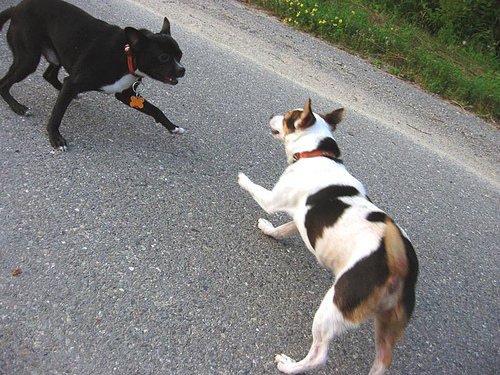

In [ ]:
Image(images_path+'/'+list(train_validate_image_caption.keys())[1]+'.jpg')

In [ ]:
# initialise tokenizer
tokenizer = Tokenizer()

# create word count dictionary on the captions list
tokenizer.fit_on_texts(list(train_validate_image_caption.values()))

# how many words are there in the vocabulary? store the total length in vocab_len and add 1 because word_index starts with 1 not 0 
vocab_len = len(tokenizer.word_index) + 1

# store the length of the maximum sentence
max_len = max(len(train_validate_image_caption[image].split()) for image in train_validate_image_caption)

def prepare_data(image_keys):
    
    # x1 will store the image feature, x2 will store one sequence and y will store the next sequence
    x1, x2, y = [], [], []

    # iterate through all the images 
    for image in image_keys:

        # store the caption of that image
        caption = train_validate_image_caption[image]

        # split the image into tokens
        caption = caption.split()

        # generate integer sequences of the
        seq = tokenizer.texts_to_sequences([caption])[0]

        length = len(seq)

        for i in range(1, length):

            x2_seq, y_seq = seq[:i] , seq[i]  

            # pad the sequences
            x2_seq = pad_sequences([x2_seq], maxlen = max_len)[0]


            # encode the output sequence                
            y_seq = to_categorical([y_seq], num_classes = vocab_len)[0]

            x1.append( train_validate_features[image][0] )

            x2.append(x2_seq)

            y.append(y_seq)
               
    return np.array(x1), np.array(x2), np.array(y)

In [ ]:
train_x1, train_x2, train_y = prepare_data( train_validate_images[0:7081] )
validate_x1, validate_x2, validate_y = prepare_data( train_validate_images[7081:8081] )

In [ ]:
len(train_x1)

71343

In [ ]:
len(validate_x1)

10167

In [ ]:
# feature extractor model
input_1 = Input(shape=(4096,))
droplayer = Dropout(0.5)(input_1)
denselayer = Dense(256, activation='relu')(droplayer)

# sequence model
input_2 = Input(shape=(max_len,))
embedding = Embedding(vocab_len, 256, mask_zero=True)(input_2)
droplayer_ = Dropout(0.5)(embedding)
lstm = LSTM(256)(droplayer_)

# decoder model
decoder1 = add([denselayer, lstm])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_len, activation='softmax')(decoder2)

# tie it together [image, seq] [word]
model = Model(inputs=[input_1, input_2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# summarize model
print(model.summary())

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 30)]         0           []                               
                                                                                                  
 input_8 (InputLayer)           [(None, 4096)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 30, 256)      1143808     ['input_9[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 4096)         0           ['input_8[0][0]']                
                                                                                            

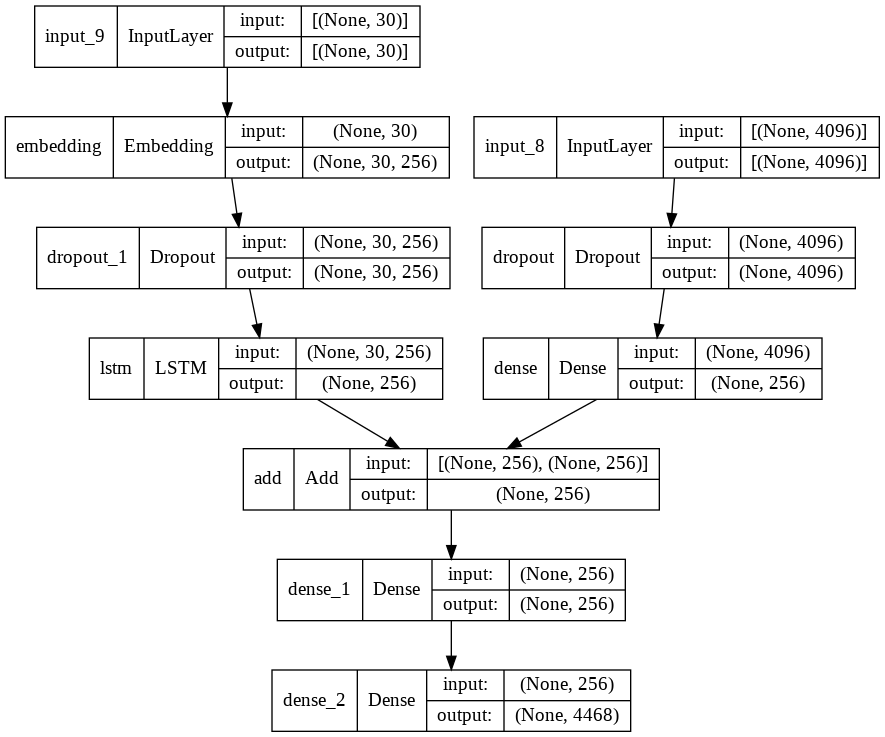

In [ ]:
plot_model(model, to_file='model.png', show_shapes=True)

In [ ]:
# define checkpoint callback
filepath = './model-ep{epoch:02d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5'

callbacks = [
             ModelCheckpoint(filepath= filepath, save_best_only=True, monitor='val_loss') ]

In [ ]:
print("shape of train_x1 ", train_x1.shape)
print("shape of train_x2 ", train_x2.shape)
print("shape of train_y ", train_y.shape)
print()
print("shape of validate_x1 ", validate_x1.shape)
print("shape of validate_x2 ", validate_x2.shape)
print("shape of validate_y ", validate_y.shape)

shape of train_x1  (71343, 4096)
shape of train_x2  (71343, 30)
shape of train_y  (71343, 4468)

shape of validate_x1  (10167, 4096)
shape of validate_x2  (10167, 30)
shape of validate_y  (10167, 4468)


In [ ]:
# fit model
history = model.fit([train_x1, train_x2],  
                    train_y,              
                    verbose = 1,            
                    epochs = 20,            
                    callbacks = callbacks, 
                    validation_data=([validate_x1, validate_x2], validate_y))

Epoch 1/20
2230/2230 [==============================] - ETA: 0s - loss: 5.1137

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


2230/2230 [==============================] - 495s 220ms/step - loss: 5.1137 - val_loss: 4.6437
Epoch 2/20
2230/2230 [==============================] - 484s 217ms/step - loss: 4.2755 - val_loss: 4.3887
Epoch 3/20
2230/2230 [==============================] - 488s 219ms/step - loss: 3.9490 - val_loss: 4.3370
Epoch 4/20
2230/2230 [==============================] - 479s 215ms/step - loss: 3.7270 - val_loss: 4.3553
Epoch 5/20
2230/2230 [==============================] - 471s 211ms/step - loss: 3.5584 - val_loss: 4.3948
Epoch 6/20
2230/2230 [==============================] - 499s 224ms/step - loss: 3.4130 - val_loss: 4.5294
Epoch 7/20
2230/2230 [==============================] - 483s 216ms/step - loss: 3.2954 - val_loss: 4.5890
Epoch 8/20
2230/2230 [==============================] - 486s 218ms/step - loss: 3.1940 - val_loss: 4.6950
Epoch 9/20
2230/2230 [==============================] - 488s 219ms/step - loss: 3.0998 - val_loss: 4.8243
Epoch 10/20
2230/2230 [==============================] - 

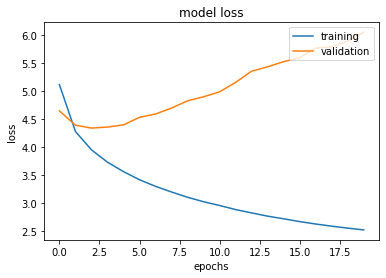

In [ ]:
# plot training loss and validation loss
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

In [ ]:
# saving the model with last parameter 
model.save('./latest_model.h5')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [ ]:
# extract features from each photo in the directory
def extract_feat(filename):
    # load the model
    model = VGG16()
    # re-structure the model
    model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
    # load the photo
    image = load_img(filename, target_size=(224, 224))
    # convert the image pixels to a numpy array
    image = img_to_array(image)
    # reshape data for the model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # prepare the image for the VGG model
    image = preprocess_input(image)
    # get features
    feature = model.predict(image, verbose=0)
    return feature

# map an integer to a word
def word_for_id(integer, tokenizr):
    for word, index in tokenizr.word_index.items():
        if index == integer:
            return word
    return None

In [ ]:
# generate a description for an image
def generate_desc(model, tokenizer, photo, max_length):
    # seed the generation process
    in_text = 'startseq'
    # iterate over the whole length of the sequence
    for i in range(max_length):
        # integer encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad input
        sequence = pad_sequences([sequence], maxlen=max_length)
        # predict next word
        yhat = model.predict([photo,sequence], verbose=0)
        # convert probability to integer
        yhat = np.argmax(yhat)
        # map integer to word
        word = word_for_id(yhat, tokenizer)
        # stop if we cannot map the word
        if word is None:
            break
        # append as input for generating the next word
        in_text += ' ' + word
        # stop if we predict the end of the sequence
        if word == 'endseq':
            break
    return in_text

In [ ]:
from keras.models import load_model
# load the model
modl = load_model('./latest_model.h5')

# generate description
tokenizr = Tokenizer()
tokenizr.fit_on_texts([caption for image, caption in new_captions_dict.items() if image in train_validate_images])
max_length = 30

for count in range(10):

    photo = extract_feat('{}.jpg'.format(images_path+'/'+train_validate_images[count]))  

    # generate description
    description = generate_desc(modl, tokenizr, photo, max_length)
    print("Predicted caption -> ", description)
    print()
    print("Actual caption -> ", new_captions_dict[train_validate_images[count]])
    print('*********************************************************************')
    print()

Predicted caption ->  startseq brown dog is running through the water endseq

Actual caption ->  startseq black and white colored dog jumping around in body of water endseq
*********************************************************************

Predicted caption ->  startseq brown dog is running through field endseq

Actual caption ->  startseq brown dog is jumping after tennis ball endseq
*********************************************************************

Predicted caption ->  startseq boy in red shirt and white shorts is riding bike on skateboard endseq

Actual caption ->  startseq man sits on deck taking break from fishing endseq
*********************************************************************

Predicted caption ->  startseq group of people are riding through the city endseq

Actual caption ->  startseq man without shirt on is guiding large brown horse pulling green and yellow wagon endseq
*********************************************************************

Predicted captio

In [ ]:
# load the model
modl = load_model('./latest_model.h5')

# generate description
tokenizr = Tokenizer()
tokenizr.fit_on_texts([caption for image, caption in new_captions_dict.items() if image in test_images])
max_length = 30

for count in range(10):

    photo = extract_feat('{}.jpg'.format(images_path+'/'+test_images[count]))  

    # generate description
    description = generate_desc(modl, tokenizr, photo, max_length)
    print("Predicted caption -> ", description)
    print()
    print("Actual caption -> ", new_captions_dict[test_images[count]])
    print('*********************************************************************')
    print()

Predicted caption ->  startseq are the to backyard is black teal endseq

Actual caption ->  startseq blond dog runs down flight of stairs to the backyard endseq
*********************************************************************

Predicted caption ->  startseq down the to backyard is black white endseq

Actual caption ->  startseq black and white dog stands neck deep in clear water endseq
*********************************************************************

Predicted caption ->  startseq down in man the to backyard is black teal endseq

Actual caption ->  startseq black and black dog are running side by side endseq
*********************************************************************

Predicted caption ->  startseq stands and down blond to

Actual caption ->  startseq in red and pink walking down large steps endseq
*********************************************************************

Predicted caption ->  startseq stands and neck

Actual caption ->  startseq man stands on mountaint

In [ ]:
# load the model
modl = load_model('/content/model-ep01-loss5.114-val_loss4.644.h5')

# generate description
tokenizr = Tokenizer()
tokenizr.fit_on_texts([caption for image, caption in new_captions_dict.items() if image in test_images])
max_length = 30

for count in range(10):

    photo = extract_feat('{}.jpg'.format(images_path+'/'+test_images[count]))  

    # generate description
    description = generate_desc(modl, tokenizr, photo, max_length)
    print("Predicted caption -> ", description)
    print()
    print("Actual caption -> ", new_captions_dict[test_images[count]])
    print('*********************************************************************')
    print()

Predicted caption ->  startseq are the to backyard and black white endseq

Actual caption ->  startseq blond dog runs down flight of stairs to the backyard endseq
*********************************************************************

Predicted caption ->  startseq are the to backyard and black white endseq

Actual caption ->  startseq black and white dog stands neck deep in clear water endseq
*********************************************************************

Predicted caption ->  startseq down the to backyard and black white endseq

Actual caption ->  startseq black and black dog are running side by side endseq
*********************************************************************

Predicted caption ->  startseq stands and neck blond to to to to to to to to to to to to to to to to to to to to to to to to to to

Actual caption ->  startseq in red and pink walking down large steps endseq
*********************************************************************

Predicted caption ->  start

In [ ]:
# load the model
modl = load_model('/content/model-ep02-loss4.275-val_loss4.389.h5')

# generate description
tokenizr = Tokenizer()
tokenizr.fit_on_texts([caption for image, caption in new_captions_dict.items() if image in test_images])
max_length = 30

for count in range(10):

    photo = extract_feat('{}.jpg'.format(images_path+'/'+test_images[count]))  

    # generate description
    description = generate_desc(modl, tokenizr, photo, max_length)
    print("Predicted caption -> ", description)
    print()
    print("Actual caption -> ", new_captions_dict[test_images[count]])
    print('*********************************************************************')
    print()

Predicted caption ->  startseq are the to backyard and black hats endseq

Actual caption ->  startseq blond dog runs down flight of stairs to the backyard endseq
*********************************************************************

Predicted caption ->  startseq down the to backyard and black hats endseq

Actual caption ->  startseq black and white dog stands neck deep in clear water endseq
*********************************************************************

Predicted caption ->  startseq are the to backyard and black hats endseq

Actual caption ->  startseq black and black dog are running side by side endseq
*********************************************************************

Predicted caption ->  startseq stands and down blond to plays dog black

Actual caption ->  startseq in red and pink walking down large steps endseq
*********************************************************************

Predicted caption ->  startseq stands and neck blond to plays dog black hats endseq

Actu

In [ ]:
# load the model
modl = load_model('/content/model-ep03-loss3.949-val_loss4.337.h5')

# generate description
tokenizr = Tokenizer()
tokenizr.fit_on_texts([caption for image, caption in new_captions_dict.items() if image in test_images])
max_length = 30

for count in range(10):

    photo = extract_feat('{}.jpg'.format(images_path+'/'+test_images[count]))  

    # generate description
    description = generate_desc(modl, tokenizr, photo, max_length)
    print("Predicted caption -> ", description)
    print()
    print("Actual caption -> ", new_captions_dict[test_images[count]])
    print('*********************************************************************')
    print()

Predicted caption ->  startseq are the to backyard dog black teal endseq

Actual caption ->  startseq blond dog runs down flight of stairs to the backyard endseq
*********************************************************************

Predicted caption ->  startseq down the to backyard is black white endseq

Actual caption ->  startseq black and white dog stands neck deep in clear water endseq
*********************************************************************

Predicted caption ->  startseq down the to backyard is black hats endseq

Actual caption ->  startseq black and black dog are running side by side endseq
*********************************************************************

Predicted caption ->  startseq stands and walking blond to plays dog black

Actual caption ->  startseq in red and pink walking down large steps endseq
*********************************************************************

Predicted caption ->  startseq stands and neck blond to plays dog black by endseq

Act